# <font color = "blue">Curiosity Driven Exploration to Optimize Structure-Property Learning in Microscopy</font>

### Aditya Vatsavai<sup>1,2</sup> Ganesh Narasimha<sup>1</sup>, Yongtao Liu<sup>1</sup>, Jan-Chi Yang<sup>3</sup>, Hiroshi Funakubo<sup>4</sup>, Maxim Ziatdinov<sup>5</sup> and Rama Vasudevan<sup>1</sup>

<sup>1</sup>Center for Nanophase Materials Sciences, Oak Ridge National Laboratory, Oak Ridge, TN, USA <br>
<sup>2</sup>Department of Physics, University of North Carolina, Charlotte <br>
<sup>3</sup>Department of Physics, National Cheng Kung University, Tianan, Taiwan <br>
<sup>4</sup>Tokyo Institute of Technology
<sup>5</sup>Physical Sciences Division, Pacific Northwest National Laboratory, Richland, WA, USA

Here we are going to perform curiosity-based sampling using a latent space model (second part of the paper). In this algorithm, we train an autoencoder on image patches. We then train a secondary error prediction model based on the latent space embeddings to predict the error from new image patches for the im2spec (or spec2im) models. In this notebook, this is done for a pre-acquired dataset.

## Import Packages

Let's import the necessary packages

In [1]:
import os
import sys
import tqdm
import pickle
sys.path.insert(0, os.path.join(os.getcwd(), 'im2spec'))
                
import numpy as np
import random
import scipy
import h5py
import matplotlib.pyplot as plt
import sidpy as sid
from copy import deepcopy as dc

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

from im2spec.models import conv_block, dilated_block
from im2spec.utils import create_training_set, predict, encode, decode
from im2spec.train_utils import trainer

from functions import *
from functions import rewards_model

# Load and plot the data

This is a pre-acquired dataset on a (110) oriented, 200nm-thick PbTiO<sub>3</sub> thin film sample grown on a substrate of SrTiO<sub>3</sub>. The datasetconsists of a 50x50 switching spectroscopy piezoresponse force microscopy dataset, captured on a Vero Cypher atomic force microscope. We will load the dataset, convert the data to 'Polarization' (A*cos(phi)) and then plot a hysteresis loop. We will focus on the so-called 'off-field' response, i.e. the piezoresponse is measured when no DC voltage is applied.

In [2]:
#Get data file
h5_f = h5py.File(r'../Data Files/PTO_SSPFM.h5', 'r+')
my_dict = h5_f['ForceMap']
max_rows, max_cols = find_max_in_keys(my_dict)

dset = h5_f['ForceMap']['0:0']
dc_bias_all = dset[5,:]
good_inds = np.where(~np.isnan(dc_bias_all))[0]
first_index = good_inds[0]
last_index = good_inds[-1]
dc_vec_OF_IF = dc_bias_all[first_index:last_index]
dc_vec = dc_vec_OF_IF[20::10][::2]

#Make the amplitude, phase matrices
amp_OF = np.zeros(shape=(max_rows, max_cols, len(dc_vec)))
amp_IF = np.zeros(shape=(max_rows, max_cols, len(dc_vec)))
phase_OF = np.zeros(shape=(max_rows, max_cols, len(dc_vec)))
phase_IF = np.zeros(shape=(max_rows, max_cols, len(dc_vec)))

for row in range(max_rows):
    for col in range(max_cols):
        
        dset = h5_f['ForceMap'][str(row) + ':' + str(col)]
        
        amp_resp_all = dset[2,first_index:last_index]
        phase_resp_all = dset[3,first_index:last_index]
        floor_ind = np.floor(len(amp_resp_all)/10)*10
        
        amp_resp_reshaped = amp_resp_all[:int(floor_ind)].reshape(-1,10)
        amp_resp_mean = amp_resp_reshaped.mean(axis=1)
        amp_resp_OF = amp_resp_mean[::2]
        amp_resp_IF = amp_resp_mean[1::2]

        phase_resp_reshaped = phase_resp_all[:int(floor_ind)].reshape(-1,10)
        phase_resp_mean = phase_resp_reshaped.mean(axis=1)
        phase_resp_OF = phase_resp_mean[::2]
        phase_resp_IF = phase_resp_mean[1::2]

        amp_OF[row,col,:] = amp_resp_OF
        amp_IF[row,col,:] = amp_resp_IF
        phase_OF[row,col,:] = phase_resp_OF
        phase_IF[row,col,:] = phase_resp_IF


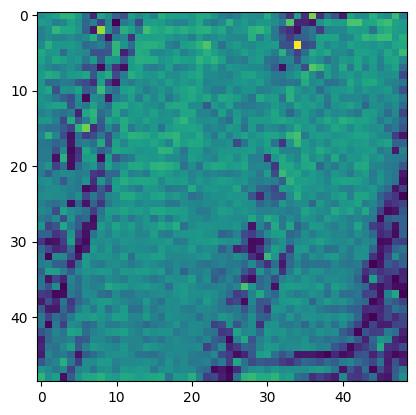

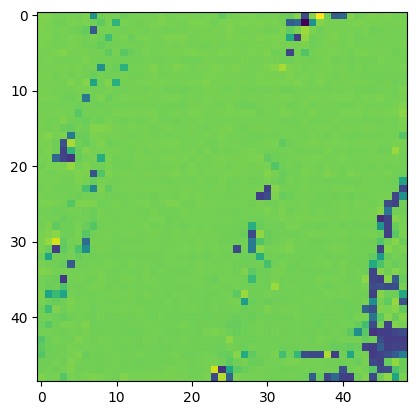

In [3]:
#amplitude and phase images

plt.figure()
plt.imshow(amp_OF[:,:,25])

plt.figure()
plt.imshow(phase_OF[:,:,25])

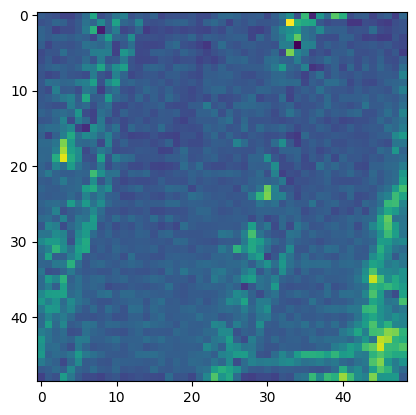

In [4]:
#Create the polarization matrix, normalize it and plot it
pola = amp_OF*np.cos(phase_OF*np.pi/180)
norm_pola = 2/(pola.max() - pola.min()) * pola - 2/(pola.max() - pola.min()) * pola.min() - 1
norm_pola = np.array(norm_pola, dtype = np.float32)
plt.imshow(pola[:,:, 25])

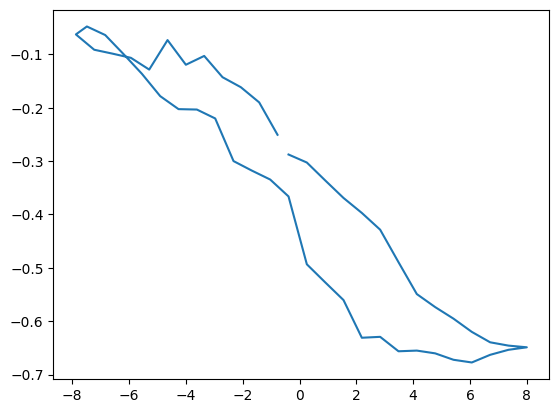

In [5]:
#example hysteresis loop

plt.plot(dc_vec[49:], norm_pola[0, 25, 49:])

In [6]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cpu


# Curiosity algorithm

Here we set up some parameters of the models. These include parameters such as the number of initialization points, the total number of measurements, the size of the image patches, and other hyperparameters.

In [46]:
start = [25, 25] #initial measurement location 
initialize = 30 #number of initialization points
num_points = 100 #number of total measurements
image_patch = 9 #image patch size
image_size = 49 #image dimension (image_size x image_size)
y_dim = 50 #spectra dimension
image, spectra = norm_pola[:,:,25], norm_pola[:,:,49:]
ldim_i = 2 #im2spec latent space dimension
ldim_a = 3 #autoencoder latent space dimension 
lbda = 2 #exploration decay rate 
num_trials = 50 #number of trials for histogram

# Train an autoencoder

First we begin by training an autoencoder. Technically, we don't have a high resolution image dataset here. Instead, we are going to simply take a slice of the lower resolution spectral dataset and treat it as our 'image'. This will be a decent approximation. 

In [22]:
#train autoencoder

radius = int((image_patch - 1)/2)
pos_X = []
X = []
y = []
for i in range(radius, image_size - radius):
    for j in range(radius, image_size - radius):
        pos_X.append([i, j])
        ind = pos_X[-1]
        X.append( get_image_patch(image, ind, image_patch))
        y.append(spectra[ind[0], ind[1]])
X = np.array(X)
y = np.array(y)
X = X.reshape([X.shape[0], 1, image_patch, image_patch])
y = y.reshape([y.shape[0], 1, y_dim])

X_tensor = torch.tensor(X).to(device)
y_tensor = torch.tensor(y).to(device)

autoencoder = im2im((image_patch, image_patch), ldim_a).to(device)
autoencoder = trainer(autoencoder, X, X, X, X, num_epochs=30, savename="im2spec_lv{}".format(10)).run()

Epoch: 1... Training loss: 0.01077... Test loss: 0.00192
Epoch: 2... Training loss: 0.00927... Test loss: 0.00336
Epoch: 3... Training loss: 0.00811... Test loss: 0.00575
Epoch: 4... Training loss: 0.00714... Test loss: 0.00649
Epoch: 5... Training loss: 0.00633... Test loss: 0.00599
Epoch: 6... Training loss: 0.00563... Test loss: 0.00651
Epoch: 7... Training loss: 0.00501... Test loss: 0.00599
Epoch: 8... Training loss: 0.00447... Test loss: 0.00437
Epoch: 9... Training loss: 0.00398... Test loss: 0.00341
Epoch: 10... Training loss: 0.00357... Test loss: 0.00353
Epoch: 11... Training loss: 0.0032... Test loss: 0.00404
Epoch: 12... Training loss: 0.00288... Test loss: 0.00383
Epoch: 13... Training loss: 0.00259... Test loss: 0.00356
Epoch: 14... Training loss: 0.00233... Test loss: 0.00214
Epoch: 15... Training loss: 0.00211... Test loss: 0.00227
Epoch: 16... Training loss: 0.0019... Test loss: 0.00206
Epoch: 17... Training loss: 0.00173... Test loss: 0.00186
Epoch: 18... Training los

## Run the curiosiy algorithm

Here we run the curiosity algorithm in an active learning way. In this implementaiton in the code cell below, we do not use Monte-Carlo Dropout (MCD). 

In [47]:
#curiosity algorithm 

loss_list = []
max_loss_list = []
actions_taken = []
#We repeat this for a number of trials to obtain statistics
for k in tqdm.tqdm(range(num_trials)):

    model = im2spec((image_patch, image_patch), y_dim, latent_dim = ldim_i).to(device)
    model_criterion = torch.nn.MSELoss()
    model_optimizer = optim.AdamW(model.parameters(), lr=0.001)
    model.eval()
    
    error_predictor = rewards_model(ldim_a).to(device)
    err_criterion = torch.nn.MSELoss()
    err_optimizer = optim.Adam(error_predictor.parameters(), lr=0.01)
    env = environment(image, spectra, start = start, image_patch = image_patch, image_size = image_size, y_dim = y_dim)
    featurizer = autoencoder
    im_feat = feature_extractor(featurizer, X)
    im_feat = im_feat.reshape([im_feat.shape[0], 1, im_feat.shape[1]]).to(device)
    action = start
    reward = [0]
    e_list = []
    max_e_list = []
    ep_list = []
    eu_list = []
    dist_reward_list = []
    lat_reward_list = []
    loss = []
    reward_list = []
    actions_list = []
    
    for i in range(initialize):
       
        while env.measured[action[0], action[1]] == 1:
            action[0] = random.randint(radius, image_size - radius -1)
            action[1] = random.randint(radius, image_size - radius -1)
            actions_list.append(action)
        
        env.step(action, False)
    
    actions_taken.append(actions_list)
    
    for i in range(5*initialize):
        model_train(model, np.array(env.X), np.array(env.y), model_criterion, model_optimizer)

        y_pred = np.array(model(X_tensor.to(device)).cpu().detach())
        err = (((y_pred - y)**2).sum(axis = 2)/y_dim).reshape(image_size - 2*radius, image_size - 2*radius)
        loss.append(err.sum())

    pred = model(torch.tensor(np.array(env.X).reshape([len(env.X), 1, image_patch, image_patch])).to(device)).cpu()
    gt = torch.tensor(np.array(env.y).reshape([len(env.y), 1, y_dim]))
    err_i = (((gt - pred)**2).sum(axis = 2)/y_dim).reshape(gt.shape[0])
    for i in range(2):
        model_train(model, np.array(env.X), np.array(env.y), model_criterion, model_optimizer)

    pred = model(torch.tensor(np.array(env.X).reshape([len(env.X), 1, image_patch, image_patch])).to(device)).cpu()
    err_f = (((gt - pred)**2).sum(axis = 2)/y_dim).reshape(gt.shape[0])
    
    reward = (err_i + err_f).detach()

    reward_list.append(reward)

    reward = reward / reward.mean()
    
    for i in range(2*initialize):
        err_train(error_predictor, np.array(env.X), np.array(reward), err_criterion, err_optimizer, featurizer)

    err_mean = np.zeros([image_size - 2*radius, image_size - 2*radius])
    err_std = np.zeros([image_size - 2*radius, image_size - 2*radius])
    dist_reward = np.zeros([image_size, image_size])
    lat_reward = np.zeros([image_size - 2*radius, image_size - 2*radius])

    
    while env.num_measure < num_points:

        if random.randint(1, 10)//10:
            ep_list.append(err_mean)
            eu_list.append(err_std)
            dist_reward_list.append(dist_reward)
            lat_reward_list.append(lat_reward)
            while env.measured[action[0], action[1]] == 1:
                action[0] = random.randint(radius, image_size - radius -1)
                action[1] = random.randint(radius, image_size - radius -1)
        else:
            err_pred_list = []
            for i in range(500):
                err_pred_list.append(np.array(error_predictor(im_feat).reshape(X.shape[0]).detach().cpu()))
            err_pred_list = np.array(err_pred_list)
            err_mean = err_pred_list.mean(axis = 0)
            err_mean = err_mean/err_mean.mean()
            err_std = err_pred_list.std(axis = 0)
            err_std = err_std/err_std.mean()
            ep_list.append(err_mean)
            eu_list.append(err_std)
            for i in range(image_size):
                for j in range(image_size):
                    if [i, j] in env.pos_X:
                        dist_reward[i, j] = 0
                    else:
                        dist_reward[i, j] = (((np.array(env.pos_X) - np.array([i, j]))**2).sum(axis = 1)**-0.5).sum()**-1
            dist_reward = dist_reward/dist_reward.mean()
            dist_reward_list.append(dist_reward)
            
            lat_reward = np.zeros((image_size - 2*radius)**2)
            lat = feature_extractor(model, X).detach().numpy()
            lat_m = feature_extractor(model, np.array(env.X).reshape([len(env.X), 1, image_patch, image_patch])).detach().numpy()
            for i in range((image_size - 2*radius)**2):
                lat_reward[i] += (((lat_m - lat[i])**2).sum(axis = 1)**-0.5).sum()**-1
            
            lat_reward = lat_reward.reshape(image_size - 2*radius, image_size - 2*radius)
            lat_reward = lat_reward/lat_reward.mean()
            lat_reward_list.append(lat_reward)

     
            aq = err_mean.copy()*(1 - np.exp(-lbda * env.num_measure/num_points)) + lat_reward.copy().reshape(-1) * np.exp(-lbda * env.num_measure/num_points)
            while pos_X[aq.argmax()] in env.pos_X:
                aq[aq.argmax()] = aq.min()
            action_list = []
            for i in range(10):
                action_list.append([aq.argmax()//(image_size - 2*radius) +radius, aq.argmax()%(image_size - 2*radius) + radius])
                aq[aq.argmax()] = aq.min()
            
            action = random.choice(action_list)
        
        env.step(action, True)
        
        pred = model(torch.tensor(np.array(env.X).reshape([len(env.X), 1, image_patch, image_patch])).to(device)).cpu()
        gt = torch.tensor(np.array(env.y).reshape([len(env.y), 1, y_dim]))
        err_i = (((gt - pred)**2).sum(axis = 2)/y_dim).reshape(gt.shape[0])
        for i in range(2):
            model_train(model, np.array(env.X), np.array(env.y), model_criterion, model_optimizer)
        
        y_pred = np.array(model(X_tensor.to(device)).detach().cpu())
        err = (((y_pred - y)**2).sum(axis = 2)/y_dim).reshape(image_size - 2*radius, image_size - 2*radius)
        e_list.append(err)
        max_e_list.append(np.sort(e_list[-1].reshape(-1))[-10:].mean())

        loss.append(err.sum())
        pred = model(torch.tensor(np.array(env.X).reshape([len(env.X), 1, image_patch, image_patch])).to(device)).cpu()
        err_f = (((gt - pred)**2).sum(axis = 2)/y_dim).reshape(gt.shape[0])
        
        reward = (err_i + err_f).detach()

        reward_list.append(reward)
        
     
        reward = reward/reward.mean()
        
        for i in range(20):
            err_train(error_predictor, np.array(env.X), np.array(reward), err_criterion, err_optimizer, featurizer)

    
        print(env.num_measure, end = "\r")
        
    loss_list.append(min(loss))
    print("Completed iteration {}, loss is {:.2f}".format(k, min(loss)))
    max_loss_list.append(min(max_e_list))

  0%|                                                    | 0/50 [00:00<?, ?it/s]

/var/folders/r8/pgjpxss144164gvc52xvk_cj12sy6v/T/ipykernel_85364/3105885694.py:109: RuntimeWarning: divide by zero encountered in power
  lat_reward[i] += (((lat_m - lat[i])**2).sum(axis = 1)**-0.5).sum()**-1


  2%|▊                                        | 1/50 [02:13<1:48:55, 133.39s/it]

Completed iteration 0, loss is 13.48


  4%|█▋                                       | 2/50 [04:27<1:47:00, 133.76s/it]

Completed iteration 1, loss is 13.26


  6%|██▍                                      | 3/50 [06:39<1:44:05, 132.89s/it]

Completed iteration 2, loss is 13.69


  8%|███▎                                     | 4/50 [08:52<1:42:00, 133.06s/it]

Completed iteration 3, loss is 13.46


 10%|████                                     | 5/50 [11:04<1:39:32, 132.73s/it]

Completed iteration 4, loss is 13.42


 12%|████▉                                    | 6/50 [13:18<1:37:29, 132.94s/it]

Completed iteration 5, loss is 13.44


 14%|█████▋                                   | 7/50 [15:33<1:35:44, 133.60s/it]

Completed iteration 6, loss is 13.22


 16%|██████▌                                  | 8/50 [17:51<1:34:30, 135.02s/it]

Completed iteration 7, loss is 13.41


 18%|███████▍                                 | 9/50 [20:03<1:31:46, 134.30s/it]

Completed iteration 8, loss is 13.67


 20%|████████                                | 10/50 [22:14<1:28:46, 133.16s/it]

Completed iteration 9, loss is 13.73


 22%|████████▊                               | 11/50 [24:32<1:27:34, 134.73s/it]

Completed iteration 10, loss is 13.37


 24%|█████████▌                              | 12/50 [26:48<1:25:35, 135.15s/it]

Completed iteration 11, loss is 13.13


 26%|██████████▍                             | 13/50 [29:12<1:24:59, 137.83s/it]

Completed iteration 12, loss is 13.55


 28%|███████████▏                            | 14/50 [31:33<1:23:10, 138.61s/it]

Completed iteration 13, loss is 13.60


 30%|████████████                            | 15/50 [34:06<1:23:24, 142.99s/it]

Completed iteration 14, loss is 13.60


 32%|████████████▊                           | 16/50 [36:39<1:22:49, 146.17s/it]

Completed iteration 15, loss is 13.60


 34%|█████████████▌                          | 17/50 [39:16<1:22:04, 149.23s/it]

Completed iteration 16, loss is 12.94


 36%|██████████████▍                         | 18/50 [41:51<1:20:29, 150.93s/it]

Completed iteration 17, loss is 13.19


 38%|███████████████▏                        | 19/50 [44:36<1:20:11, 155.21s/it]

Completed iteration 18, loss is 12.77


 40%|████████████████                        | 20/50 [47:20<1:19:00, 158.00s/it]

Completed iteration 19, loss is 13.02


 42%|████████████████▊                       | 21/50 [49:36<1:13:10, 151.41s/it]

Completed iteration 20, loss is 13.23


 44%|█████████████████▌                      | 22/50 [51:47<1:07:48, 145.31s/it]

Completed iteration 21, loss is 13.10


 46%|██████████████████▍                     | 23/50 [54:04<1:04:14, 142.78s/it]

Completed iteration 22, loss is 13.29


 48%|███████████████████▏                    | 24/50 [56:34<1:02:42, 144.70s/it]

Completed iteration 23, loss is 13.31


 50%|████████████████████                    | 25/50 [59:02<1:00:46, 145.86s/it]

Completed iteration 24, loss is 13.55


 52%|████████████████████▊                   | 26/50 [1:01:25<57:59, 144.96s/it]

Completed iteration 25, loss is 13.56


 54%|█████████████████████▌                  | 27/50 [1:03:52<55:47, 145.54s/it]

Completed iteration 26, loss is 13.08


 56%|██████████████████████▍                 | 28/50 [1:06:15<53:07, 144.90s/it]

Completed iteration 27, loss is 13.62


 58%|███████████████████████▏                | 29/50 [1:08:44<51:08, 146.10s/it]

Completed iteration 28, loss is 13.30


 60%|████████████████████████                | 30/50 [1:10:59<47:33, 142.65s/it]

Completed iteration 29, loss is 13.53


 62%|████████████████████████▊               | 31/50 [1:13:25<45:31, 143.75s/it]

Completed iteration 30, loss is 13.15


 64%|█████████████████████████▌              | 32/50 [1:15:49<43:09, 143.87s/it]

Completed iteration 31, loss is 13.24


 66%|█████████████████████████             | 33/50 [1:35:04<2:06:41, 447.17s/it]

Completed iteration 32, loss is 13.94


 68%|█████████████████████████▊            | 34/50 [1:37:34<1:35:27, 357.99s/it]

Completed iteration 33, loss is 13.97


 70%|██████████████████████████▌           | 35/50 [1:40:16<1:14:49, 299.27s/it]

Completed iteration 34, loss is 13.57


 72%|███████████████████████████▎          | 36/50 [1:59:00<2:07:31, 546.55s/it]

Completed iteration 35, loss is 13.26


 74%|████████████████████████████          | 37/50 [2:17:09<2:33:40, 709.23s/it]

Completed iteration 36, loss is 13.62


 76%|████████████████████████████         | 38/50 [2:46:47<3:25:59, 1029.92s/it]

Completed iteration 37, loss is 13.53


 78%|████████████████████████████▊        | 39/50 [3:37:58<5:01:04, 1642.19s/it]

Completed iteration 38, loss is 13.91


 80%|█████████████████████████████▌       | 40/50 [3:57:23<4:09:51, 1499.12s/it]

Completed iteration 39, loss is 14.28


 82%|██████████████████████████████▎      | 41/50 [4:15:14<3:25:35, 1370.60s/it]

Completed iteration 40, loss is 13.50


 84%|███████████████████████████████      | 42/50 [4:17:31<2:13:25, 1000.71s/it]

Completed iteration 41, loss is 13.79


 86%|████████████████████████████████▋     | 43/50 [4:20:02<1:26:59, 745.64s/it]

Completed iteration 42, loss is 13.56


 88%|███████████████████████████████████▏    | 44/50 [4:22:26<56:30, 565.09s/it]

Completed iteration 43, loss is 13.14


 90%|████████████████████████████████████    | 45/50 [4:24:56<36:43, 440.63s/it]

Completed iteration 44, loss is 13.57


 92%|████████████████████████████████████▊   | 46/50 [4:27:24<23:31, 352.81s/it]

Completed iteration 45, loss is 13.52


 94%|█████████████████████████████████████▌  | 47/50 [4:29:52<14:34, 291.37s/it]

Completed iteration 46, loss is 13.27


 96%|██████████████████████████████████████▍ | 48/50 [4:32:27<08:20, 250.49s/it]

Completed iteration 47, loss is 14.07


 98%|███████████████████████████████████████▏| 49/50 [4:34:58<03:40, 220.62s/it]

Completed iteration 48, loss is 13.66


100%|████████████████████████████████████████| 50/50 [4:37:27<00:00, 332.95s/it]

Completed iteration 49, loss is 13.80


## Plot the results of the active learning curiosity algorithm exploration

Let's take a look at the exploration path, and how well the model has performed

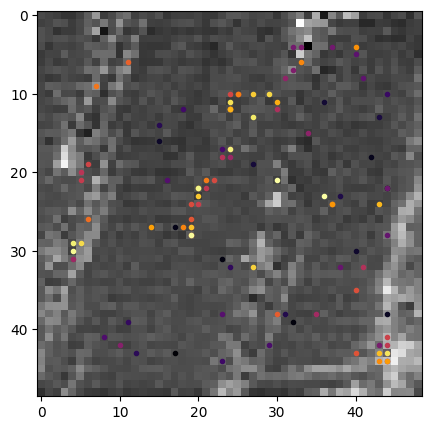

In [48]:
#exploration path

fig, axes = plt.subplots(nrows=1,ncols=1,figsize=(5,5))
axes.imshow(image, cmap = 'gray')
colors = plt.get_cmap('inferno', env.num_measure)
for ind,point in enumerate(env.pos_X):
    
    axes.plot(point[1], point[0], marker='.', color = colors(ind))

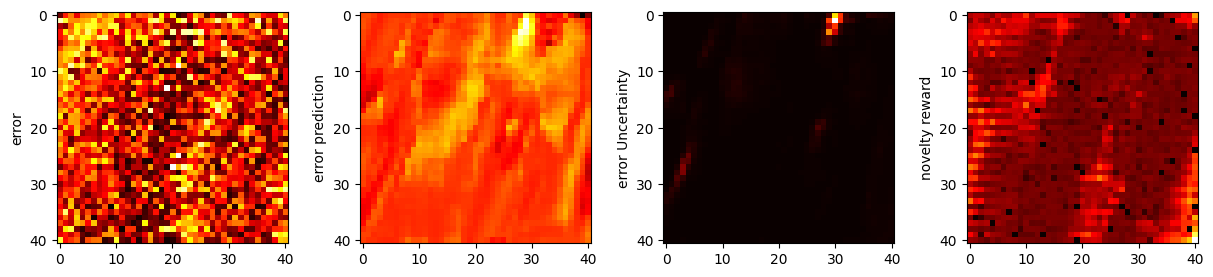

In [49]:
i = 3
fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (15, 3))

ax1.imshow(np.arctan(e_list[i]*100), cmap='hot', interpolation='nearest')
ax1.set_ylabel('error')

ax2.imshow(ep_list[i].reshape(image_size - 2*radius, image_size - 2*radius), cmap='hot', interpolation='nearest')
#ax2.plot(pos_X[ep_list[i].argmax()][1] - radius, pos_X[ep_list[i].argmax()][0] - radius, marker='.')
ax2.set_ylabel('error prediction')

ax3.imshow(np.exp(eu_list[i]).reshape(image_size - 2*radius, image_size - 2*radius), cmap='hot', interpolation='nearest')
ax3.set_ylabel('error Uncertainty')

ax4.imshow(lat_reward_list[i], cmap='hot', interpolation='nearest')
ax4.set_ylabel("novelty reward")
plt.show()

# Now Compare against Random Sampling

In [50]:
# Now starting from the same initial points, do random exploration instead to see how it compares
#random sampling

rand_max_loss_list = []
rand_loss_list = []

for k in tqdm.tqdm(range(num_trials)):

    model = im2spec((image_patch, image_patch), y_dim, ldim_i).to(device)
    model_criterion = torch.nn.MSELoss()
    model_optimizer = optim.AdamW(model.parameters(), lr=0.001)
    model.eval()
    
    error_predictor = rewards_model(ldim_a).to(device)
    err_criterion = torch.nn.MSELoss()
    err_optimizer = optim.Adam(error_predictor.parameters(), lr=0.01)
    env = environment(image, spectra, start = start, image_patch = image_patch, image_size = image_size, y_dim = y_dim)
    featurizer = autoencoder
    im_feat = feature_extractor(featurizer, X)
    im_feat = im_feat.reshape([im_feat.shape[0], 1, im_feat.shape[1]]).to(device)
    action = start
    reward = [0]
    e_list = []
    max_e_list = []
    ep_list = []
    eu_list = []
    dist_reward_list = []
    loss = []
    reward_list = []
    
    for i in range(initialize):

        #while env.measured[action[0], action[1]] == 1:
        action = actions_taken[k][i]        
        env.step(action, False)

    for i in range(5*initialize):
        model_train(model, np.array(env.X), np.array(env.y), model_criterion, model_optimizer)

        y_pred = np.array(model(X_tensor.to(device)).cpu().detach())
        err = (((y_pred - y)**2).sum(axis = 2)/y_dim).reshape(image_size - 2*radius, image_size - 2*radius)
        loss.append(err.sum())

    pred = model(torch.tensor(np.array(env.X).reshape([len(env.X), 1, image_patch, image_patch])).to(device)).cpu()
    gt = torch.tensor(np.array(env.y).reshape([len(env.y), 1, y_dim]))
    err_i = (((gt - pred)**2).sum(axis = 2)/y_dim).reshape(gt.shape[0])
    for i in range(2):
        model_train(model, np.array(env.X), np.array(env.y), model_criterion, model_optimizer)

    pred = model(torch.tensor(np.array(env.X).reshape([len(env.X), 1, image_patch, image_patch])).to(device)).cpu()
    err_f = (((gt - pred)**2).sum(axis = 2)/y_dim).reshape(gt.shape[0])
    
    reward = (err_i + err_f).detach()
    reward_list.append(reward)
    reward = reward / reward.mean()
    
    for i in range(2*initialize):
        err_train(error_predictor, np.array(env.X), np.array(reward), err_criterion, err_optimizer, featurizer)

    err_mean = np.zeros([image_size - 2*radius, image_size - 2*radius])
    err_std = np.zeros([image_size - 2*radius, image_size - 2*radius])
    dist_reward = np.zeros([image_size, image_size])
 
    while env.num_measure < num_points:

        ep_list.append(err_mean)
        eu_list.append(err_std)
        dist_reward_list.append(dist_reward)
        
        while env.measured[action[0], action[1]] == 1:
            action[0] = random.randint(radius, image_size - radius -1)
            action[1] = random.randint(radius, image_size - radius -1)
       
        
        env.step(action, True)
        
        pred = model(torch.tensor(np.array(env.X).reshape([len(env.X), 1, image_patch, image_patch])).to(device)).cpu()
        gt = torch.tensor(np.array(env.y).reshape([len(env.y), 1, y_dim]))
        err_i = (((gt - pred)**2).sum(axis = 2)/y_dim).reshape(gt.shape[0])
        
        for i in range(2):
            model_train(model, np.array(env.X), np.array(env.y), model_criterion, model_optimizer)
        y_pred = np.array(model(X_tensor.to(device)).detach().cpu())
        err = (((y_pred - y)**2).sum(axis = 2)/y_dim).reshape(image_size - 2*radius, image_size - 2*radius)
        e_list.append(err)
        max_e_list.append(np.sort(e_list[-1].reshape(-1))[-10:].mean())

        loss.append(err.sum())
        pred = model(torch.tensor(np.array(env.X).reshape([len(env.X), 1, image_patch, image_patch])).to(device)).cpu()
        err_f = (((gt - pred)**2).sum(axis = 2)/y_dim).reshape(gt.shape[0])
        
        reward = (err_i + err_f).detach()
        reward_list.append(reward)     
        reward = reward/reward.mean()

        print(env.num_measure, end = "\r")
    print("Completed iteration {}, loss is {:.2f}".format(k, min(loss)))
    rand_loss_list.append(min(loss))
    rand_max_loss_list.append(min(max_e_list))
    

  0%|                                                    | 0/50 [00:00<?, ?it/s]

  2%|▉                                           | 1/50 [00:46<38:16, 46.86s/it]

Completed iteration 0, loss is 14.83


  4%|█▊                                          | 2/50 [01:38<39:47, 49.74s/it]

Completed iteration 1, loss is 13.76


  6%|██▋                                         | 3/50 [02:26<38:12, 48.77s/it]

Completed iteration 2, loss is 13.93


  8%|███▌                                        | 4/50 [03:13<37:02, 48.32s/it]

Completed iteration 3, loss is 13.66


 10%|████▍                                       | 5/50 [04:01<36:03, 48.07s/it]

Completed iteration 4, loss is 15.92


 12%|█████▎                                      | 6/50 [04:48<35:01, 47.75s/it]

Completed iteration 5, loss is 15.45


 14%|██████▏                                     | 7/50 [05:35<34:07, 47.61s/it]

Completed iteration 6, loss is 14.30


 16%|███████                                     | 8/50 [06:23<33:15, 47.50s/it]

Completed iteration 7, loss is 13.79


 18%|███████▉                                    | 9/50 [07:11<32:32, 47.63s/it]

Completed iteration 8, loss is 14.20


 20%|████████▌                                  | 10/50 [07:58<31:44, 47.62s/it]

Completed iteration 9, loss is 15.55


 22%|█████████▍                                 | 11/50 [08:46<30:57, 47.62s/it]

Completed iteration 10, loss is 14.25


 24%|██████████▎                                | 12/50 [09:33<30:04, 47.49s/it]

Completed iteration 11, loss is 13.88


 26%|███████████▏                               | 13/50 [10:20<29:14, 47.43s/it]

Completed iteration 12, loss is 14.45


 28%|████████████                               | 14/50 [11:08<28:26, 47.40s/it]

Completed iteration 13, loss is 13.63


 30%|████████████▉                              | 15/50 [11:55<27:41, 47.48s/it]

Completed iteration 14, loss is 14.57


 32%|█████████████▊                             | 16/50 [12:43<26:57, 47.56s/it]

Completed iteration 15, loss is 14.56


 34%|██████████████▌                            | 17/50 [13:32<26:20, 47.89s/it]

Completed iteration 16, loss is 14.75


 36%|███████████████▍                           | 18/50 [14:19<25:24, 47.63s/it]

Completed iteration 17, loss is 15.94


 38%|████████████████▎                          | 19/50 [15:08<24:48, 48.03s/it]

Completed iteration 18, loss is 13.96


 40%|█████████████████▏                         | 20/50 [15:55<23:53, 47.78s/it]

Completed iteration 19, loss is 14.50


 42%|██████████████████                         | 21/50 [16:42<23:02, 47.68s/it]

Completed iteration 20, loss is 14.40


 44%|██████████████████▉                        | 22/50 [17:30<22:12, 47.60s/it]

Completed iteration 21, loss is 13.89


 46%|███████████████████▊                       | 23/50 [18:18<21:33, 47.90s/it]

Completed iteration 22, loss is 14.21


 48%|████████████████████▋                      | 24/50 [19:07<20:50, 48.09s/it]

Completed iteration 23, loss is 13.90


 50%|█████████████████████▌                     | 25/50 [19:57<20:15, 48.62s/it]

Completed iteration 24, loss is 16.89


 52%|██████████████████████▎                    | 26/50 [20:47<19:41, 49.24s/it]

Completed iteration 25, loss is 14.50


 54%|███████████████████████▏                   | 27/50 [21:38<19:02, 49.67s/it]

Completed iteration 26, loss is 14.74


 56%|████████████████████████                   | 28/50 [22:27<18:10, 49.58s/it]

Completed iteration 27, loss is 15.38


 58%|████████████████████████▉                  | 29/50 [23:17<17:22, 49.64s/it]

Completed iteration 28, loss is 14.32


 60%|█████████████████████████▊                 | 30/50 [24:06<16:30, 49.51s/it]

Completed iteration 29, loss is 13.59


 62%|██████████████████████████▋                | 31/50 [24:56<15:43, 49.63s/it]

Completed iteration 30, loss is 13.52


 64%|███████████████████████████▌               | 32/50 [25:46<14:51, 49.51s/it]

Completed iteration 31, loss is 15.53


 66%|████████████████████████████▍              | 33/50 [26:35<14:01, 49.48s/it]

Completed iteration 32, loss is 15.13


 68%|█████████████████████████████▏             | 34/50 [27:25<13:13, 49.59s/it]

Completed iteration 33, loss is 13.65


 70%|██████████████████████████████             | 35/50 [28:13<12:15, 49.06s/it]

Completed iteration 34, loss is 15.22


 72%|██████████████████████████████▉            | 36/50 [29:01<11:22, 48.78s/it]

Completed iteration 35, loss is 13.53


 74%|███████████████████████████████▊           | 37/50 [29:49<10:32, 48.68s/it]

Completed iteration 36, loss is 14.37


 76%|████████████████████████████████▋          | 38/50 [30:37<09:41, 48.43s/it]

Completed iteration 37, loss is 14.73


 78%|█████████████████████████████████▌         | 39/50 [31:25<08:50, 48.20s/it]

Completed iteration 38, loss is 14.67


 80%|██████████████████████████████████▍        | 40/50 [32:13<08:03, 48.32s/it]

Completed iteration 39, loss is 14.16


 82%|███████████████████████████████████▎       | 41/50 [33:01<07:13, 48.13s/it]

Completed iteration 40, loss is 13.93


 84%|████████████████████████████████████       | 42/50 [33:50<06:26, 48.28s/it]

Completed iteration 41, loss is 14.31


 86%|████████████████████████████████████▉      | 43/50 [34:38<05:37, 48.26s/it]

Completed iteration 42, loss is 13.79


 88%|█████████████████████████████████████▊     | 44/50 [35:26<04:49, 48.29s/it]

Completed iteration 43, loss is 13.36


 90%|██████████████████████████████████████▋    | 45/50 [36:14<04:00, 48.16s/it]

Completed iteration 44, loss is 14.86


 92%|██████████████████████████████████████▋   | 46/50 [54:49<24:33, 368.26s/it]

Completed iteration 45, loss is 13.84


 94%|███████████████████████████████████████▍  | 47/50 [55:30<13:30, 270.03s/it]

Completed iteration 46, loss is 15.28


 96%|████████████████████████████████████████▎ | 48/50 [56:13<06:43, 201.76s/it]

Completed iteration 47, loss is 13.50


 98%|███████████████████████████████████████▏| 49/50 [1:11:58<07:04, 424.93s/it]

Completed iteration 48, loss is 15.55


100%|█████████████████████████████████████████| 50/50 [1:12:39<00:00, 87.19s/it]

Completed iteration 49, loss is 14.17


In [51]:
print(np.mean(loss_list), np.std(loss_list))
print(np.mean(rand_loss_list), np.std(rand_loss_list))

13.470048 0.2941132
14.456196 0.75399303


# Plot Curiosity vs. Random Sampling

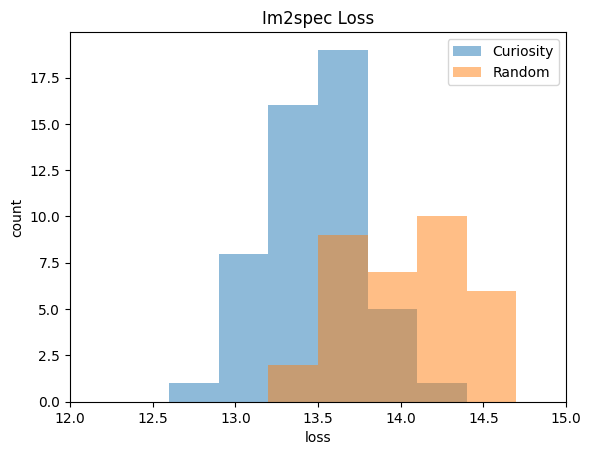

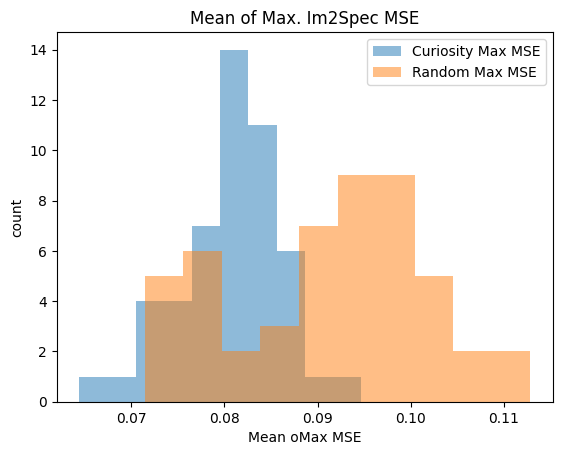

In [52]:
#histograms


plt.figure()
bins = np.arange(12, 15, 0.3)
plt.xlim([12, 15])
plt.hist(loss_list, bins=bins, alpha=0.5, label = "Curiosity")
plt.hist(rand_loss_list, bins=bins, alpha=0.5, label = "Random")
plt.xlabel('loss')
plt.ylabel('count')
plt.title("Im2spec Loss")
plt.legend()
plt.show()


plt.figure()
plt.hist(max_loss_list, alpha=0.5, label = "Curiosity Max MSE")
plt.hist(rand_max_loss_list, alpha=0.5, label = "Random Max MSE")
plt.xlabel('Mean oMax MSE')
plt.ylabel('count')
plt.title("Mean of Max. Im2Spec MSE")
plt.legend()
plt.show()

results_final_dict = {'curiosity':loss_list, 'random':rand_loss_list, 'curiosity_ml':max_loss_list, 'random_ml': rand_max_loss_list}

fname = 'curiosity_algo_results_t=50.p'
pickle.dump(results_final_dict, open(fname, 'wb'))

In [ ]:
i = 10

fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize = (15, 3))

ax1.imshow(np.arctan(e_list[i]*100), cmap='hot', interpolation='nearest')
ax1.set_ylabel('error')

ax2.imshow(ep_list[i].reshape(image_size - 2*radius, image_size - 2*radius), cmap='hot', interpolation='nearest')
#ax2.plot(pos_X[ep_list[i].argmax()][1] - radius, pos_X[ep_list[i].argmax()][0] - radius, marker='.')
ax2.set_ylabel('error prediction')

ax3.imshow(np.exp(eu_list[i]).reshape(image_size - 2*radius, image_size - 2*radius), cmap='hot', interpolation='nearest')
ax3.set_ylabel('error uncertainty')

ax4.imshow(lat_reward_list[i], cmap='hot', interpolation='nearest')
ax4.set_ylabel("novelty reward")
plt.show()

# Curiosity algorithm with Monte-Carlo Dropout

In reality the curiosity algorithm might do better if we string together probababilistic models. Since there is some uncertianty in our encoding as well, here we use a probabalistic im2spec model for that component. We implement this with a simple Monte-Carlo Dropout (first pioneered by Gal and Ghahramani, see <a href ="https://proceedings.mlr.press/v48/gal16.html?trk=public_post_comment-text"> here</a>). Specifically, there is uncertainty applied to the im2spec model itself.

In [54]:
#curiosity algorithm with MCD uncertainty classification

full_loss_list = []
full_max_loss_list = []

for k in range(num_trials):

    model = im2spec((image_patch, image_patch), y_dim, latent_dim = ldim_i).to(device)
    model_criterion = torch.nn.MSELoss()
    model_optimizer = optim.AdamW(model.parameters(), lr=0.001)
    model.eval()
    
    error_predictor = rewards_model(ldim_a).to(device)
    err_criterion = torch.nn.MSELoss()
    err_optimizer = optim.Adam(error_predictor.parameters(), lr=0.01)
    env = environment(image, spectra, start = start, image_patch = image_patch, image_size = image_size, y_dim = y_dim)
    featurizer = autoencoder
    im_feat = feature_extractor(featurizer, X)
    im_feat = im_feat.reshape([im_feat.shape[0], 1, im_feat.shape[1]]).to(device)
    action = start
    reward = [0]
    e_list = []
    max_e_list = []
    ep_list = []
    eu_list = []
    dist_reward_list = []
    lat_reward_list = []
    loss = []
    reward_list = []
    
    for i in range(initialize):
       
        #while env.measured[action[0], action[1]] == 1:
        action = actions_taken[k][i]        
        #action[0] = random.randint(radius, image_size - radius -1)
        #action[1] = random.randint(radius, image_size - radius -1)
        
        env.step(action, False)

    for i in range(5*initialize):
        model_train(model, np.array(env.X), np.array(env.y), model_criterion, model_optimizer)

        y_pred = np.array(model(X_tensor.to(device)).cpu().detach())
        err = (((y_pred - y)**2).sum(axis = 2)/y_dim).reshape(image_size - 2*radius, image_size - 2*radius)
        loss.append(err.sum())

    pred = model(torch.tensor(np.array(env.X).reshape([len(env.X), 1, image_patch, image_patch])).to(device)).cpu()
    gt = torch.tensor(np.array(env.y).reshape([len(env.y), 1, y_dim]))
    err_i = (((gt - pred)**2).sum(axis = 2)/y_dim).reshape(gt.shape[0])
    for i in range(2):
        model_train(model, np.array(env.X), np.array(env.y), model_criterion, model_optimizer)

    pred = model(torch.tensor(np.array(env.X).reshape([len(env.X), 1, image_patch, image_patch])).to(device)).cpu()
    err_f = (((gt - pred)**2).sum(axis = 2)/y_dim).reshape(gt.shape[0])
    
    reward = (err_i + err_f).detach()

    reward_list.append(reward)

    reward = reward / reward.mean()
    
    for i in range(2*initialize):
        err_train(error_predictor, np.array(env.X), np.array(reward), err_criterion, err_optimizer, featurizer)

    
    err_mean = np.zeros([image_size - 2*radius, image_size - 2*radius])
    err_std = np.zeros([image_size - 2*radius, image_size - 2*radius])
    dist_reward = np.zeros([image_size, image_size])
    lat_reward = np.zeros([image_size - 2*radius, image_size - 2*radius])

    
    while env.num_measure < num_points:
        if random.randint(1, 10)//10:
            ep_list.append(err_mean)
            eu_list.append(err_std)
            dist_reward_list.append(dist_reward)
            lat_reward_list.append(lat_reward)
            while env.measured[action[0], action[1]] == 1:
                action[0] = random.randint(radius, image_size - radius -1)
                action[1] = random.randint(radius, image_size - radius -1)
        else:
            err_pred_list = []
            for i in range(500):
                err_pred_list.append(np.array(error_predictor(im_feat).reshape(X.shape[0]).detach().cpu()))
                
            err_pred_list = np.array(err_pred_list)
            err_mean = err_pred_list.mean(axis = 0)
            err_mean = err_mean/err_mean.mean()
            err_std = err_pred_list.std(axis = 0)
            err_std = err_std/err_std.mean()
            ep_list.append(err_mean)
            eu_list.append(err_std)
            for i in range(image_size):
                for j in range(image_size):
                    if [i, j] in env.pos_X:
                        dist_reward[i, j] = 0
                    else:
                        dist_reward[i, j] = (((np.array(env.pos_X) - np.array([i, j]))**2).sum(axis = 1)**-0.5).sum()**-1
            dist_reward = dist_reward/dist_reward.mean()
            dist_reward_list.append(dist_reward)
            
            lat_reward = np.zeros((image_size - 2*radius)**2)
            lat = feature_extractor(model, X).detach().numpy()
            lat_m = feature_extractor(model, np.array(env.X).reshape([len(env.X), 1, image_patch, image_patch])).detach().numpy()
            for i in range((image_size - 2*radius)**2):
                lat_reward[i] = (((lat_m - lat[i])**2).sum(axis = 1)**-0.5).sum()**-1
            
            lat_reward = lat_reward.reshape(image_size - 2*radius, image_size - 2*radius)
            lat_reward = lat_reward/lat_reward.mean()
            lat_reward_list.append(lat_reward)
            
            model.train()
            
            y_pass = []
            for i in range(100):
                y_pass.append(np.array(model(X_tensor.to(device)).detach().cpu()))
            
            model.eval()
            
            y_pass = np.array(y_pass)
        
            y_unc = y_pass.std(axis = 0).mean(axis = 2)
            ep_list.append(y_unc)
            
            aq = err_mean.copy()*(1 + 2*np.exp(-lbda) - np.exp(-lbda * env.num_measure/num_points) - np.exp(lbda * (env.num_measure - num_points)/num_points)) + lat_reward.copy().reshape(-1) * np.exp(-lbda * env.num_measure/num_points) + y_unc.copy().reshape(-1) * np.exp(lbda * (env.num_measure - num_points)/num_points) # * dist_reward.copy().reshape(-1)
            
            while pos_X[aq.argmax()] in env.pos_X:
                aq[aq.argmax()] = aq.min()
            action_list = []
            for i in range(10):
                action_list.append([aq.argmax()//(image_size - 2*radius) +radius, aq.argmax()%(image_size - 2*radius) + radius])
                aq[aq.argmax()] = aq.min()
            
            action = random.choice(action_list)
        
        env.step(action, True)
        
        pred = model(torch.tensor(np.array(env.X).reshape([len(env.X), 1, image_patch, image_patch])).to(device)).cpu()
        gt = torch.tensor(np.array(env.y).reshape([len(env.y), 1, y_dim]))
        err_i = (((gt - pred)**2).sum(axis = 2)/y_dim).reshape(gt.shape[0])
        
        for i in range(2):
            model_train(model, np.array(env.X), np.array(env.y), model_criterion, model_optimizer)
        
        y_pred = np.array(model(X_tensor.to(device)).detach().cpu())
        err = (((y_pred - y)**2).sum(axis = 2)/y_dim).reshape(image_size - 2*radius, image_size - 2*radius)
        e_list.append(err)
        max_e_list.append(np.sort(e_list[-1].reshape(-1))[-10:].mean())

        loss.append(err.sum())
        pred = model(torch.tensor(np.array(env.X).reshape([len(env.X), 1, image_patch, image_patch])).to(device)).cpu()
        err_f = (((gt - pred)**2).sum(axis = 2)/y_dim).reshape(gt.shape[0])
        
        reward = (err_i + err_f).detach()
        reward_list.append(reward)
        reward = reward/reward.mean()
    
        print(env.num_measure, end = "\r")
    full_loss_list.append(min(loss))
    full_max_loss_list.append(min(max_e_list))
    

/var/folders/r8/pgjpxss144164gvc52xvk_cj12sy6v/T/ipykernel_85364/906619963.py:106: RuntimeWarning: divide by zero encountered in power
  lat_reward[i] = (((lat_m - lat[i])**2).sum(axis = 1)**-0.5).sum()**-1


In [ ]:
full_loss_list = np.array(full_loss_list)
full_loss_list.mean(), full_loss_list.std()

In [ ]:
full_max_loss_list = np.array(full_max_loss_list)
full_max_loss_list.mean(), full_max_loss_list.std()